# Group 4
# Deep Learning - CSB - Final Project
# CNN-Based Brain Tumor Detection Using MRI Images
# Classification Phase

## Importing Libraries
Additionally, a seed will be set in order to achive reproducible results.

In [ ]:
# *
import os
import cv2
import time
import math
import shutil
import random
import PIL
import posixpath
import pathlib
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from glob import glob
from PIL import Image, ImageFont
from pandas import DataFrame
from itertools import chain
from tensorflow import keras
from keras import layers
from keras.layers import *
from keras.models import *
%matplotlib inline

# Pre-Processing Data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pydot
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import CustomObjectScope, load_img, to_categorical, plot_model
from importlib import reload
from sklearn.preprocessing import LabelEncoder

# Training Model
from keras import callbacks, regularizers
import keras.backend as K
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LambdaCallback, LearningRateScheduler
from keras.models import Sequential, load_model, Model
from keras.layers import *
from keras.optimizers import Adamax
from keras.metrics import categorical_crossentropy

# Evaluation
import itertools
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

# Set Seed
from numpy.random import seed
seed(10)
tf.random.set_seed(10)
print('Imported Successfully')
%matplotlib inline

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
print('Modules loaded')

Imported Successfully
modules loaded


## Dataset
The Dataset was acquired through Kaggle. This dataset is a combination of the following three datasets:
- Figshare
- Kaggle Br35H
- Kaggle SARTAJ

This dataset contains **7023** images of human brain MRI images which are classified into 4 classes: glioma, meningioma, no tumor, and pituitary.

Dataset Link: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

#### Load the Train and Test Image

In [ ]:
# Get DataFrames.
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
train_df, valid_df, test_df = split_data(train_dir, test_dir)

#### Plot Random Images from the Train Folder

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


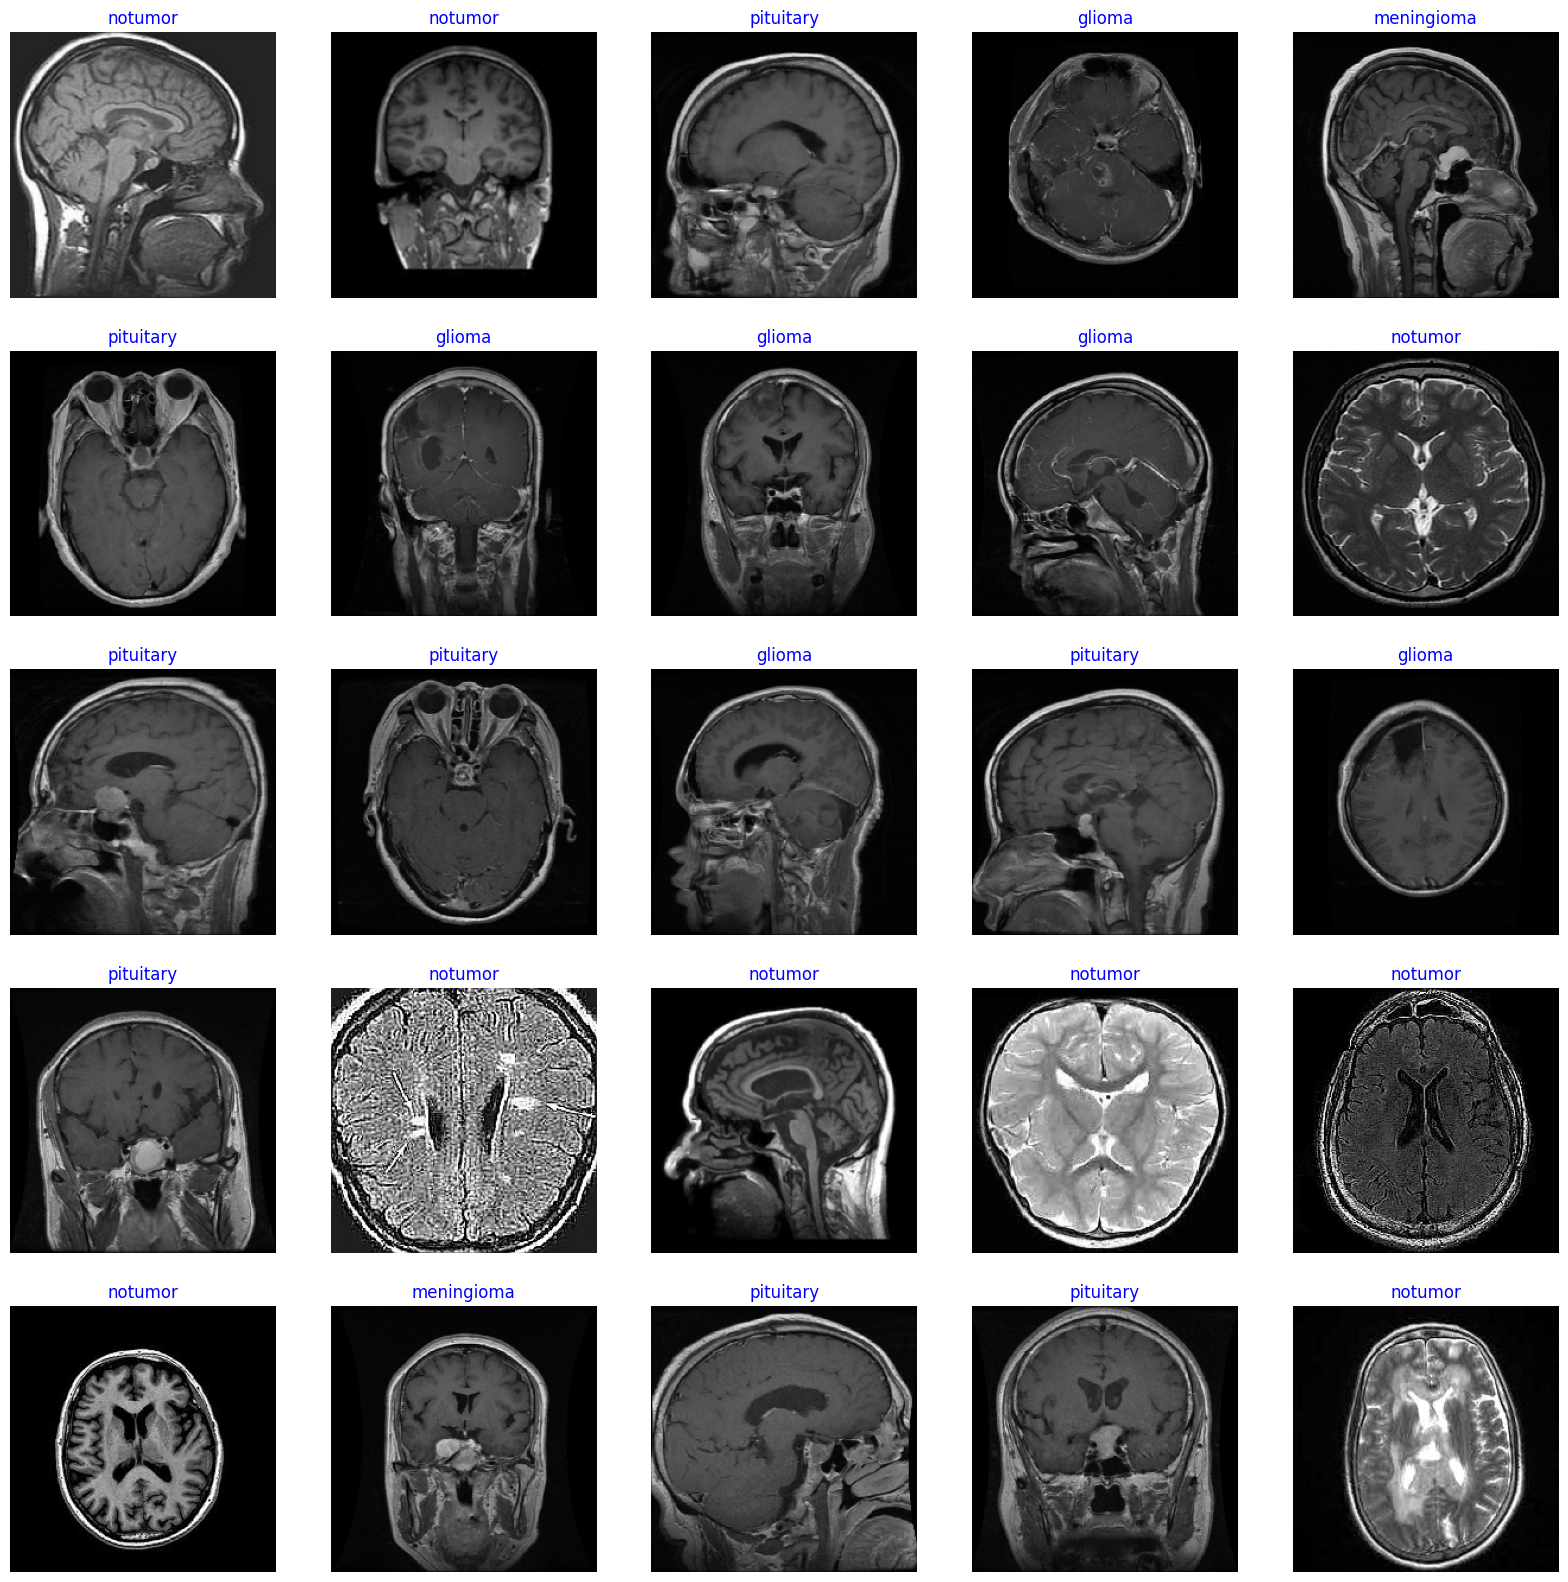

In [ ]:
# Display Image Samples.
img_folder = '/kaggle/input/brain-tumor-mri-dataset/Training'
plt.figure(figsize =(20,20))
for i in range(6):
    class_ = random.choice(os.listdir(img_folder))
    class_path = os.path.join(img_folder, class_)
    file =random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path,file)
    print(image_path)
    img = mpimg.imread(image_path)
    ax =plt.subplot(1,6,(i+1))
    plt.imshow(img)
    ax.title.set_text(class_)

## Data Pre-Processing

#### Create the Labels for Each Tumor Class

In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 256

#### Grayscaling
- Simplifying and Eliminates the Complexities

#### Bilateral Filtering
- Reduce Noise.

#### Pseudocoloring
- Enhance the Visual Representation.

#### Resizing
- 256x256 Pixels.

#### Normalization
- [0, 1] Scale.

In [ ]:
for label in labels:
    trainPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # grayscaling
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 256*256.
        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

x_train = np.array(x_train) / 255.0 # normalize images into a range of 0 to 1.
x_test = np.array(x_test) / 255.0
print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:02<00:00, 115.83it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


#### Plot Random Images after Pre-Processing

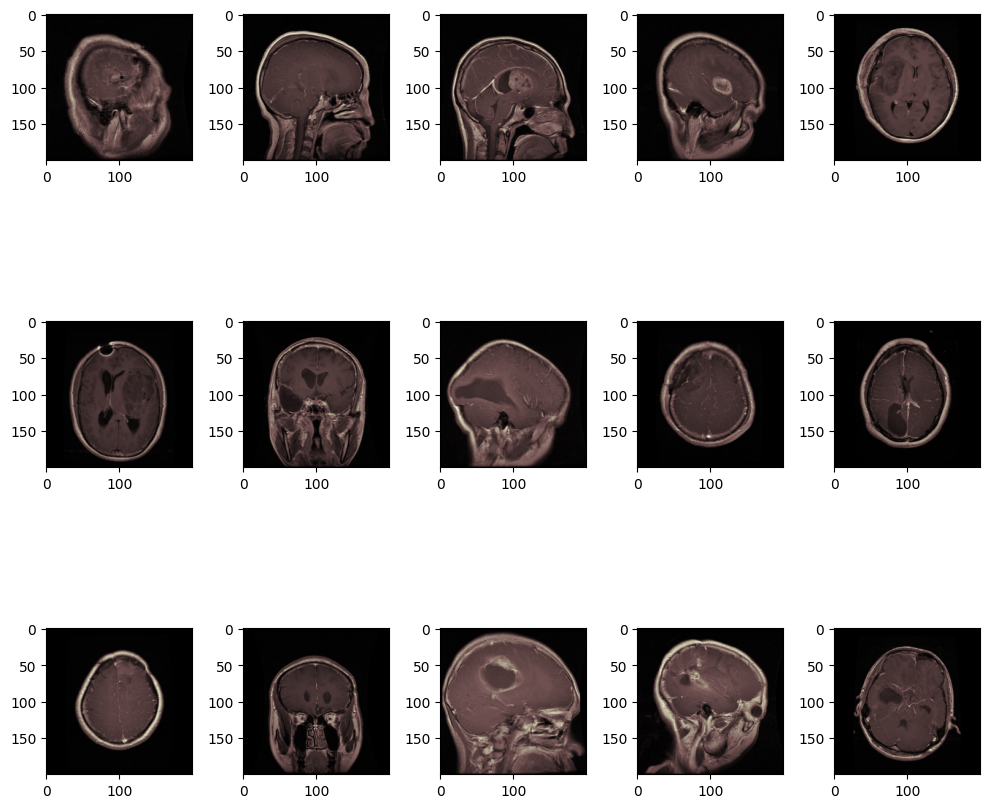

In [ ]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

#### One-Hot Encoding
- Converts the categorical labels into one-hot encoded vectors.

In [ ]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels.
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42) #Dividing into Training and Validation sets.

print(x_val.shape)

(1143, 200, 200, 3)


#### Data Augmentation
- Artificially increase the size of the training dataset by applying various random transformations of translations, rotations, etc.

In [ ]:
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.05,
                             height_shift_range=0.05, horizontal_flip=True)
datagen.fit(x_train)

In [ ]:
class_names = list(labels)

def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

# Confusion Matrix Plot
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return figure

## Modeling I | EfficientNet-B0

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # to define the number of classes in the dense layer.

base_model_effnetb0 = EfficientNetB0(include_top=False, # Do not include the ImageNet classifier at the top.
                                     weights='imagenet', # Load weights pre-trained on ImageNet.
                                     input_shape=img_shape,
                                     pooling='max')

In [ ]:
model_effnetb0 = Sequential([
    base_model_effnetb0,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model_effnetb0.compile(Adamax(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_effnetb0.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_4 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               327936    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 4383655 (16.72 MB)
Trainable params: 433

## Training I | EfficientNet-B0

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

Checkpoint = ModelCheckpoint(filepath = 'model_effnetb0.h5', # callback to save the model weights.
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'min')

ES = EarlyStopping(monitor = 'val_loss', # stop training when a monitored metric has stopped improving.
                   min_delta = 0.001,
                   patience = 5,
                   mode = 'min',
                   restore_best_weights = True,
                   verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',# reduce learning rate when a metric has stopped improving.
                       factor = 0.3,
                       patience = 5,
                       verbose = 1,
                       mode = 'min')

callbacks = [ES,RL,Checkpoint,LambdaCallback()] # set of functions at given stages of the training procedure

history_b0 = model_effnetb0.fit(x= train_gen, epochs= 20,
                                callbacks= callbacks,
                                validation_data= valid_gen)

Epoch 1/20


2023-11-20 08:23:57.366083: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


115/115 [==============================] - ETA: 0s - loss: 6.5190 - accuracy: 0.8698
Epoch 1: val_loss improved from inf to 5.14131, saving model to model_effnetb0.h5
115/115 [==============================] - 69s 303ms/step - loss: 6.5190 - accuracy: 0.8698 - val_loss: 5.1413 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 2/20
115/115 [==============================] - ETA: 0s - loss: 4.0571 - accuracy: 0.9571
Epoch 2: val_loss improved from 5.14131 to 3.41694, saving model to model_effnetb0.h5
115/115 [==============================] - 33s 290ms/step - loss: 4.0571 - accuracy: 0.9571 - val_loss: 3.4169 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 3/20
115/115 [==============================] - ETA: 0s - loss: 2.7294 - accuracy: 0.9733
Epoch 3: val_loss improved from 3.41694 to 2.46321, saving model to model_effnetb0.h5
115/115 [==============================] - 33s 288ms/step - loss: 2.7294 - accuracy: 0.9733 - val_loss: 2.4632 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 4/20
115/115 [========

## Learning Curves I | EfficientNet-B0

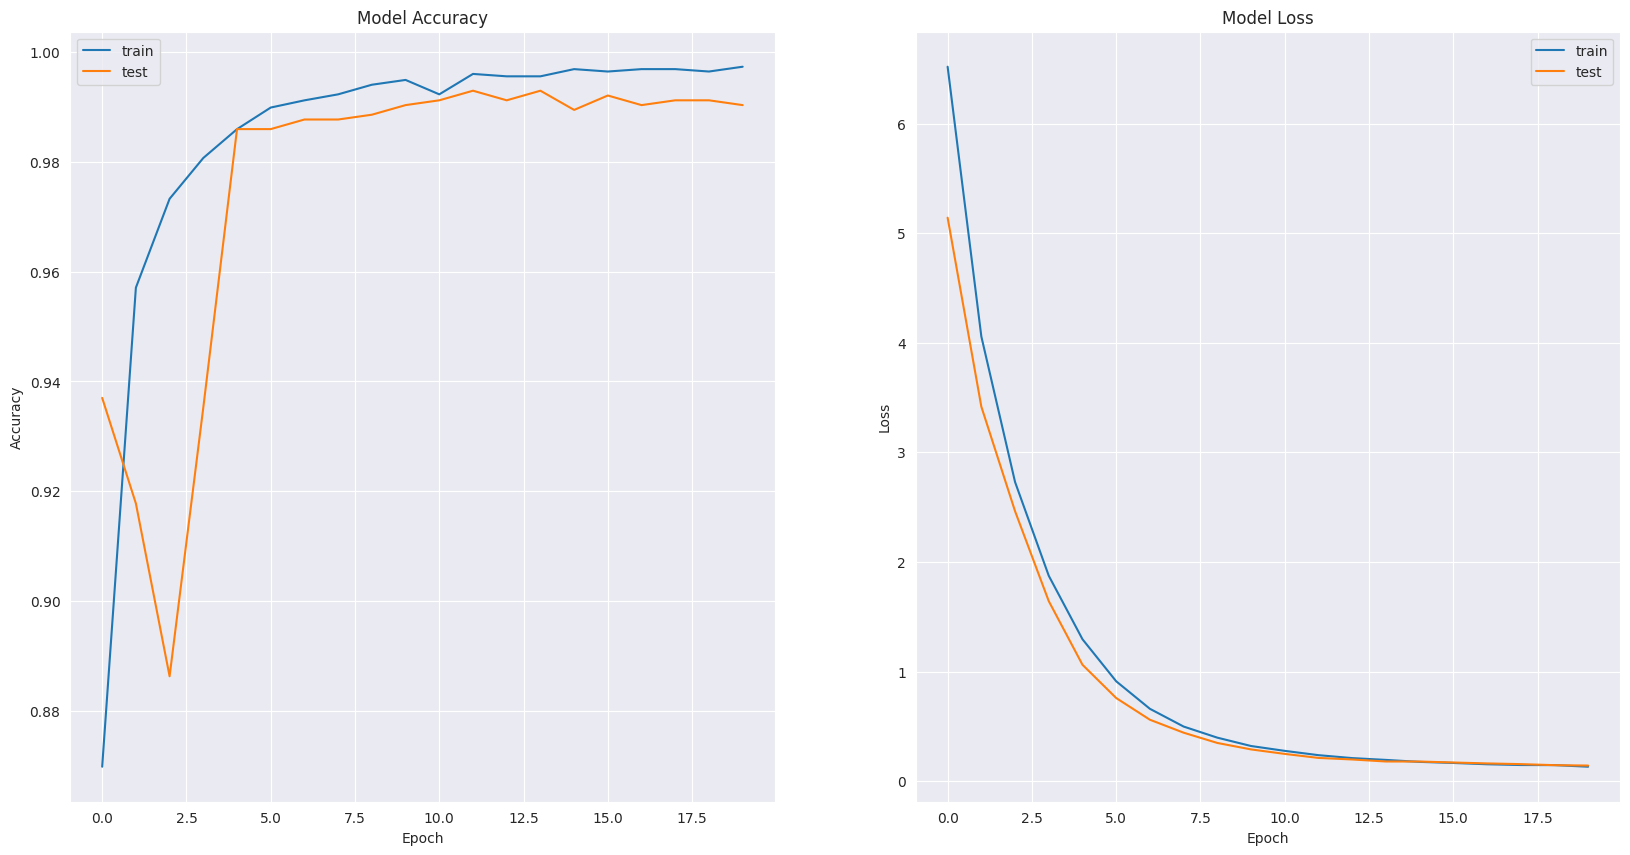

In [ ]:
# Plot Model Accuracy.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(history_b0.history['accuracy'])
plt.plot(history_b0.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')

# Plot Model Loss.
plt.subplot(1,2,2)
plt.plot(history_b0.history['loss'])
plt.plot(history_b0.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Evaluation I | EfficientNet-B0

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model_effnetb0.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model_effnetb0.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model_effnetb0.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

19/19 [==============================] - 5s 266ms/step - loss: 0.1321 - accuracy: 0.9939
Train Loss:  0.11408916115760803
Train Accuracy:  0.9986842274665833
--------------------
Validation Loss:  0.13782601058483124
Validation Accuracy:  0.9894737005233765
--------------------
Test Loss:  0.13211390376091003
Test Accuracy:  0.9938977956771851


Confusion Matrix, Without Normalization
[[297   3   0   0]
 [  0 304   2   0]
 [  0   1 404   0]
 [  0   2   0 298]]
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.98      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



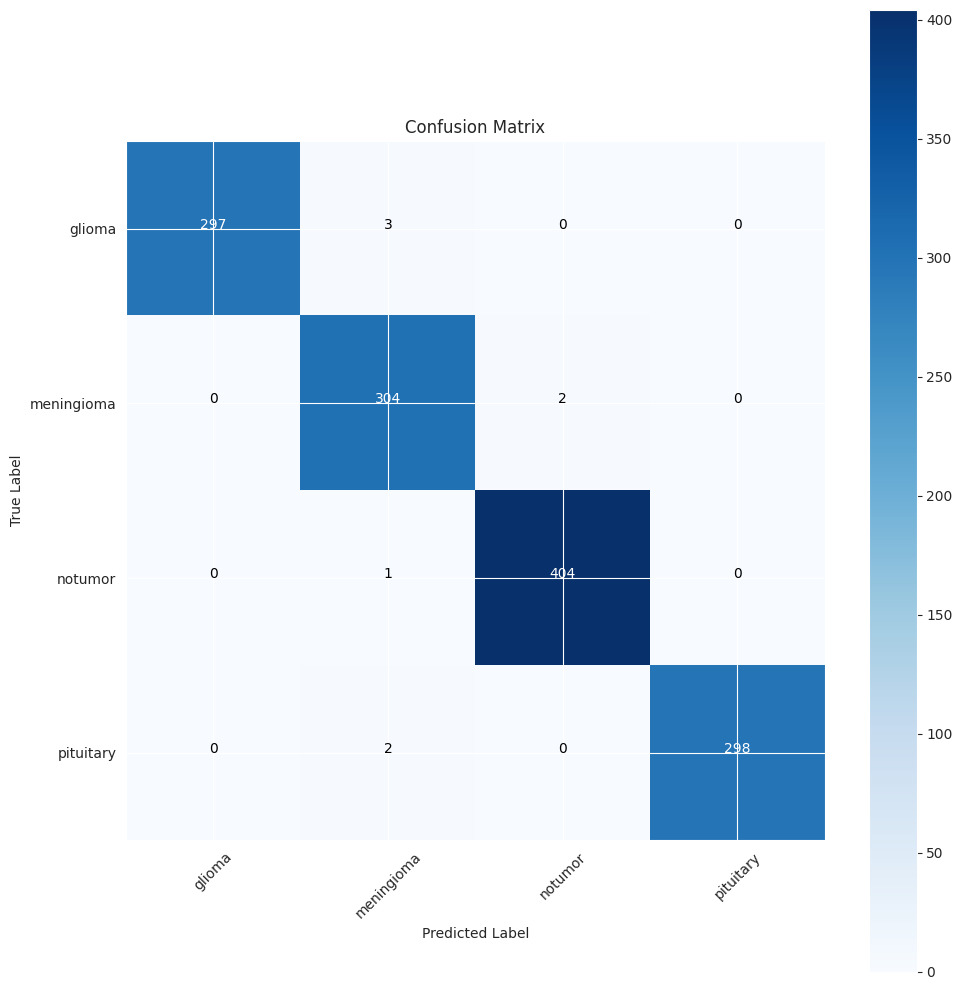

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

## Modeling II | EfficientNet-B3

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer.

base_model_effnetb3 = EfficientNetB3(include_top= False,
                                     weights= "imagenet",
                                     input_shape= img_shape,
                                     pooling= 'max')

In [ ]:
model_effnetb3 = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model_effnetb3.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

model_effnetb3.summary()

43941136/43941136 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

## Training II | EfficientNet-B3

In [ ]:
BATCH_SIZE = 64
EPOCHS = 20

Checkpoint = ModelCheckpoint(filepath = 'model_effnetb3.h5', # callback to save the model weights.
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'min')

ES = EarlyStopping(monitor = 'val_loss', # stop training when a monitored metric has stopped improving.
                   min_delta = 0.001,
                   patience = 5,
                   mode = 'min',
                   restore_best_weights = True,
                   verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',# reduce learning rate when a metric has stopped improving.
                       factor = 0.3,
                       patience = 5,
                       verbose = 1,
                       mode = 'min')

callbacks = [ES,RL,Checkpoint,LambdaCallback()] # set of functions at given stages of the training procedure

history_b3 = model_effnetb3.fit(x = train_gen,
                                epochs= 20,
                                callbacks= callbacks,
                                validation_data= valid_gen)

Epoch 1/20
115/115 [==============================] - ETA: 0s - loss: 2.9020 - accuracy: 0.9812
Epoch 1: val_loss improved from 5.29576 to 2.40783, saving model to model_effnetb3.h5
115/115 [==============================] - 59s 516ms/step - loss: 2.9020 - accuracy: 0.9812 - val_loss: 2.4078 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 2/20
115/115 [==============================] - ETA: 0s - loss: 1.9522 - accuracy: 0.9882
Epoch 2: val_loss improved from 2.40783 to 1.61594, saving model to model_effnetb3.h5
115/115 [==============================] - 59s 515ms/step - loss: 1.9522 - accuracy: 0.9882 - val_loss: 1.6159 - val_accuracy: 0.9773 - lr: 0.0010
Epoch 3/20
115/115 [==============================] - ETA: 0s - loss: 1.3229 - accuracy: 0.9923
Epoch 3: val_loss improved from 1.61594 to 1.07383, saving model to model_effnetb3.h5
115/115 [==============================] - 59s 515ms/step - loss: 1.3229 - accuracy: 0.9923 - val_loss: 1.0738 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 4/20
11

## Learning Curves II | EfficientNet-B3

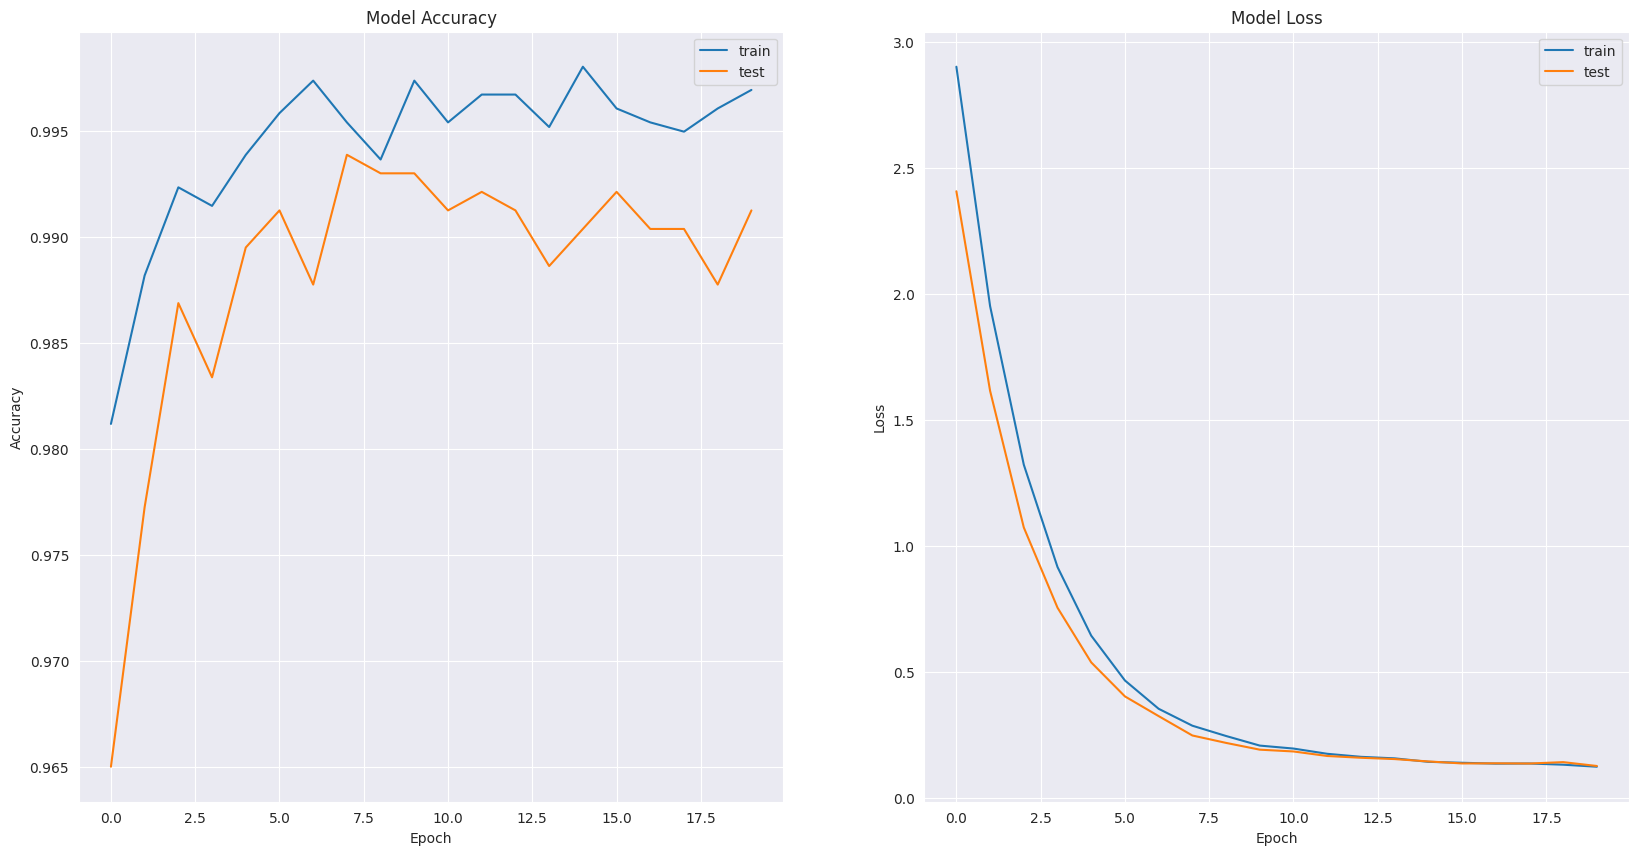

In [ ]:
# Plot Model Accuracy.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')

# Plot Model Loss.
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Evaluation | EfficientNet-B3

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

19/19 [==============================] - 10s 483ms/step - loss: 0.1206 - accuracy: 0.9931
Train Loss:  0.0992242842912674
Train Accuracy:  0.9986842274665833
--------------------
Validation Loss:  0.133231982588768
Validation Accuracy:  0.9907894730567932
--------------------
Test Loss:  0.12062631547451019
Test Accuracy:  0.9931350350379944


Confusion Matrix, Without Normalization
[[296   4   0   0]
 [  0 304   1   1]
 [  0   1 404   0]
 [  0   2   0 298]]
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.98      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



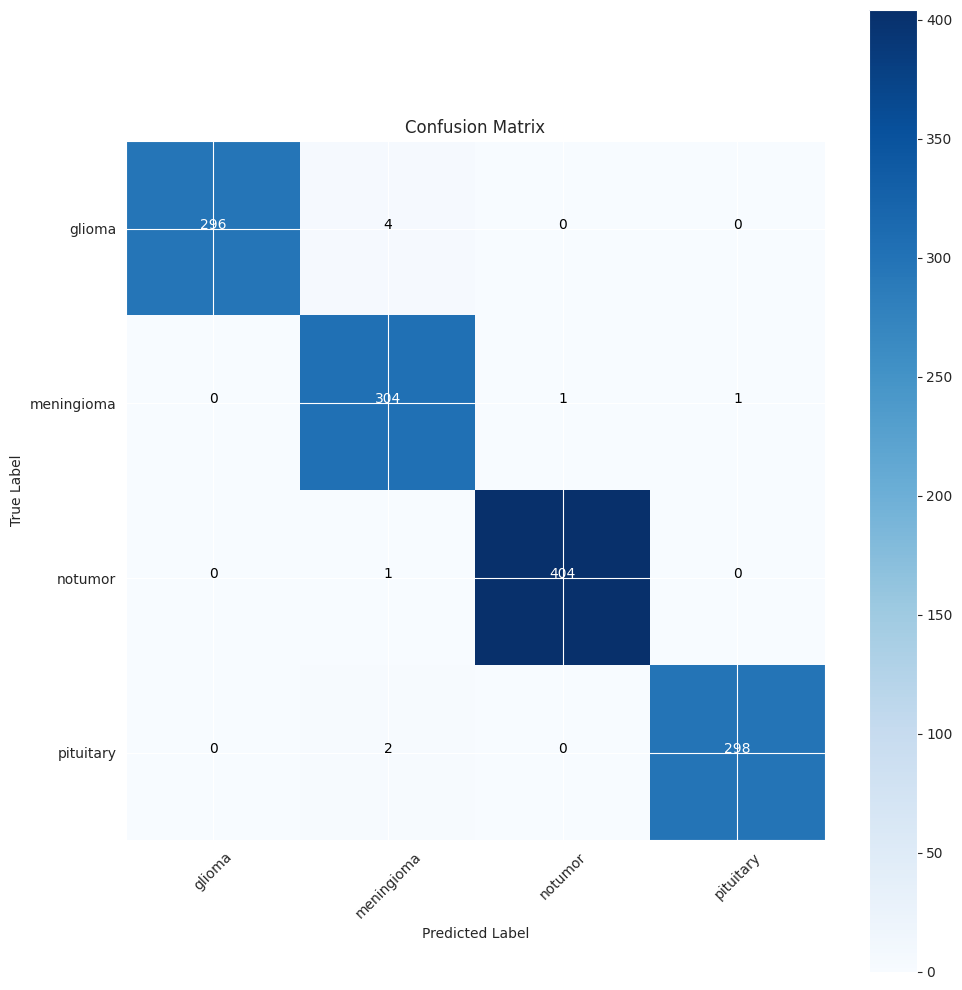

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))